# Medical costs inssurance prediction

In [1]:
#Load libraries
import warnings
warnings.filterwarnings("ignore")
import numpy
import pandas as pd
import seaborn
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## 1. Load the dataset

In [2]:
dataset = pd.read_csv('medical_costs_data.csv')
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## 2. Analyze data

In [3]:
#dimensions of the dataset
dataset.shape

(1338, 7)

We have 1338 instances to work with and can conﬁrm the data has 7 attributes including the output attribute charges.

In [4]:
#data types of each attribute
dataset.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

We can see that all of the attributes are numeric (float)

In [5]:
#peak of the data
dataset.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [6]:
#Transform categorical variables to numerical (only for EDA)
lb = LabelBinarizer().fit(dataset['sex'])
dataset_eda['sex'] = lb.transform(dataset['sex'])[:,0]
#smoker
lb = LabelBinarizer().fit(dataset_eda['smoker'])
dataset['smoker'] = lb.transform(dataset['smoker'])[:,0]
#region
lb = LabelBinarizer().fit(dataset_eda['region'])
dataset['region'] = lb.transform(dataset['region'])[:,0]

NameError: name 'LabelBinarizer' is not defined

In [7]:
#summarize the distribution of each attribute
set_option('precision', 2)
dataset.describe()

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


We now have a better feeling for how diﬀerent the attributes are. The min and max values as well are the means vary a lot. We are likely going to get better results by rescaling the data in some way.

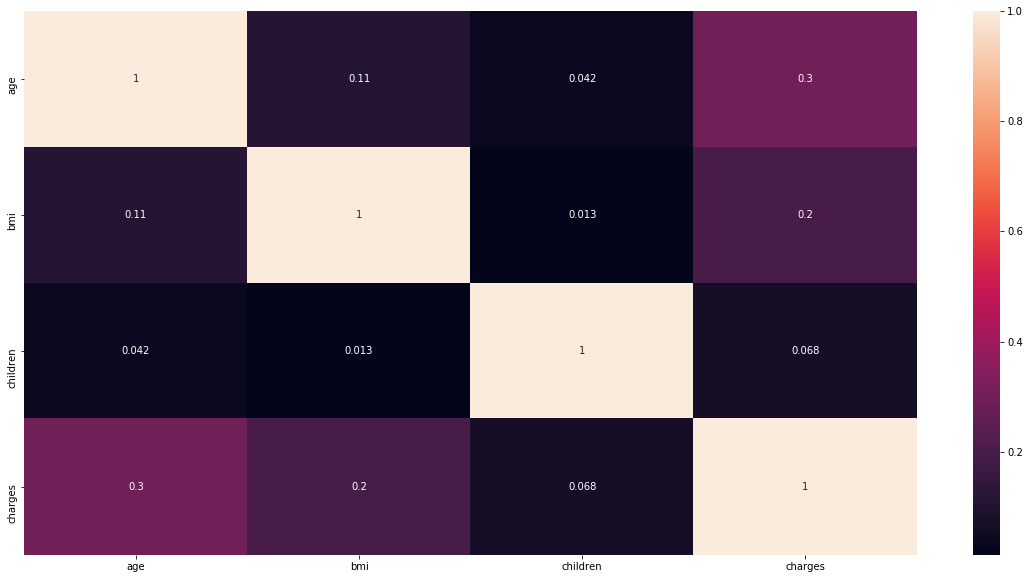

In [8]:
#take a look at the correlation between all of the numeric attributes
set_option('precision', 2)
pyplot.figure(figsize=(20,10))
seaborn.heatmap(dataset.corr(method='pearson'), annot=True)
pyplot.show()

## 3. Data visualizations
### 3.1. Unimodal data visualizations
Let’s look at visualizations of individual attributes. It is often useful to look at your data using multiple diﬀerent visualizations in order to spark ideas.

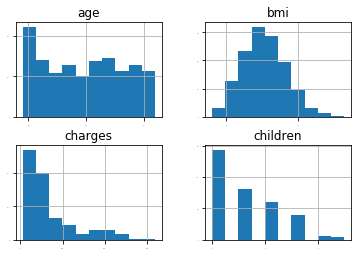

<Figure size 1440x720 with 0 Axes>

In [9]:
#histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
pyplot.figure(figsize=(20,10))
pyplot.show()

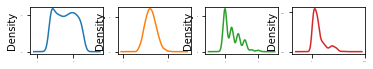

<Figure size 1440x720 with 0 Axes>

In [10]:
#density plots
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=False, fontsize=1)
pyplot.figure(figsize=(20,10))
pyplot.show()

This perhaps adds more evidence to our suspicion about possible exponential and bimodal distributions. It also looks like NOX, RM and LSTAT may be skewed Gaussian distributions, which might be helpful later with transforms.

<Figure size 432x288 with 0 Axes>

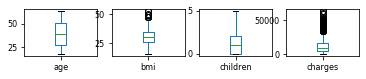

<Figure size 1440x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
#box and whiskers plots
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, fontsize=8)
pyplot.figure(figsize=(20,10))
pyplot.figure()

### 3.2. Multimodal data visualizations
Let’s look at some visualizations of the interactions between variables. The best place to start is a scatter plot matrix.

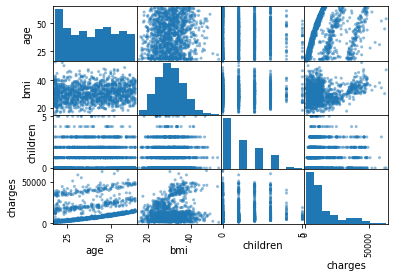

In [12]:
#scatter plot matrix
scatter_matrix(dataset)
pyplot.show()

## 4. Validation dataset
It is a good idea to use a validation hold-out set. This is a sample of the data that we hold back from our analysis and modeling. We use it right at the end of our project to conﬁrm the accuracy of our ﬁnal model. It is a smoke test that we can use to see if we messed up and to give us conﬁdence on our estimates of accuracy on unseen data. We will use 80% of the dataset for modeling and hold back 20% for validation.

In [13]:
dataset = pd.read_csv('medical_costs_data.csv')
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,30.97,3,no,northwest,10600.55
1334,18,female,31.92,0,no,northeast,2205.98
1335,18,female,36.85,0,no,southeast,1629.83
1336,21,female,25.80,0,no,southwest,2007.94


In [14]:
#split-out validation dataset
val_size = 0.2
seed = 7
idx_train, idx_val = train_test_split(dataset.index, test_size=val_size, random_state=seed)
dataset_train = dataset.loc[idx_train,:]
dataset_val = dataset.loc[idx_val,:]
dataset_train.shape, dataset_val.shape

((1070, 7), (268, 7))

In [15]:
#handle categorical data
X_categorical = dataset_train.select_dtypes(include='object')
labelencoder = LabelEncoder()
X_categorical['sex'] = labelencoder.fit_transform(X_categorical['sex'])
X_categorical['smoker'] = labelencoder.fit_transform(X_categorical['smoker'])
X_categorical['region'] = labelencoder.fit_transform(X_categorical['region'])
onehot_encoder = OneHotEncoder()
X_categorical = onehot_encoder.fit_transform(X_categorical).toarray()
X_categorical.shape

(1070, 8)

In [16]:
#handle numerical data
X_numerical = dataset_train.select_dtypes(include=['float64','int64'])
Y_train = X_numerical['charges'].values.reshape(-1,1)
X_numerical = X_numerical.drop(['charges'], axis=1).values
X_numerical.shape

(1070, 3)

In [17]:
#join X_categorical and X_numerical
X_train = numpy.hstack((X_numerical, X_categorical))
X_train.shape

(1070, 11)

## 5. Evaluate algorithms: baseline
We have no idea what algorithms will do well on this problem. Gut feel suggests regression algorithms like Linear Regression and ElasticNet may do well. It is also possible that decision trees and even SVM may do well. I have no idea. Let’s design our test harness. We will use 10-fold cross-validation. The dataset is not too small and this is a good standard test harness conﬁguration. We will evaluate algorithms using the Mean Squared Error (MSE) metric. MSE will give a gross idea of how wrong all predictions are (0 is perfect).

In [18]:
num_folds = 10
seed = 7
scoring = 'r2'

Let’s create a baseline of performance on this problem and spot-check a number of diﬀerent algorithms. We will select a suite of diﬀerent algorithms capable of working on this regression problem. The six algorithms selected include:
- Linear Algorithms: Linear Regression (LR), Lasso Regression (LASSO) and ElasticNet (EN).
- Nonlinear Algorithms: Classiﬁcation and Regression Trees (CART), Support Vector Regression (SVR) and k-Nearest Neighbors (KNN).

In [19]:
#spot-check algorithms
models = dict()
models['LR'] = LinearRegression()
models['LASSO'] = Lasso()
models['EN'] = ElasticNet()
models['KNN'] = KNeighborsRegressor()
models['CART'] = DecisionTreeRegressor()
models['SVR'] = SVR()

The algorithms all use default tuning parameters. Let’s compare the algorithms. We will display the mean and standard deviation of MSE for each algorithm as we calculate it and collect the results for use later.

In [20]:
#evaluate each model in turn
results = []
names = []
for name, model in models.items() :
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f (+-%f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.737408 (+-0.040276)
LASSO: 0.737417 (+-0.040281)
EN: 0.505167 (+-0.035559)
KNN: 0.185899 (+-0.055775)
CART: 0.733760 (+-0.072012)
SVR: -0.096981 (+-0.037972)


Let’s take a look at the distribution of scores across all cross-validation folds by algorithm.

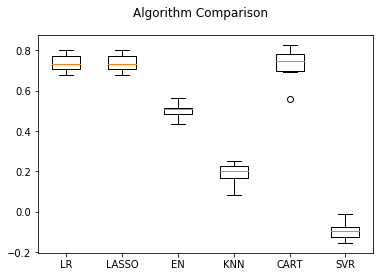

In [22]:
#compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Best models: LR (0.7374), LASSO (0.7374), CART (0.7337)

## 6. Evaluate algorithms: Standardization
We suspect that the diﬀering scales of the raw data may be negatively impacting the skill of some of the algorithms. Let’s evaluate the same algorithms with a standardized copy of the dataset. This is where the data is transformed such that each attribute has a mean value of zero and a standard deviation of 1. We also need to avoid data leakage when we transform the data. A good way to avoid leakage is to use pipelines that standardize the data and build the model for each fold in the cross-validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.

In [23]:
#standardize the dataset
pipelines = dict()
pipelines['ScaledLR'] = Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])
pipelines['ScaledLASSO'] = Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])
pipelines['ScaledEN'] = Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])
pipelines['ScaledKNN'] = Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])
pipelines['ScaledCART'] = Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])
pipelines['ScaledSVR'] = Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])
#evaluate each model in turn
results = []
names = []
for name, model in pipelines.items() :
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f (+-%f)" % (name, cv_results.mean(), cv_results.std()))

ScaledLR: 0.736905 (+-0.039344)
ScaledLASSO: 0.737415 (+-0.040273)
ScaledEN: 0.699421 (+-0.033215)
ScaledKNN: 0.772713 (+-0.033316)
ScaledCART: 0.706952 (+-0.084808)
ScaledSVR: -0.093015 (+-0.037397)


Running the example provides a list of mean squared errors. We can see that scaling did have an eﬀect on KNN and CART, driving the error lower than the other models.

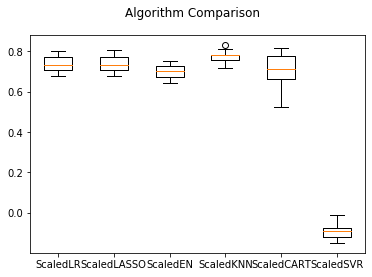

In [24]:
#compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

The best one, scaled KNN (R2 of 0.7727), better than the other models.

## 7. Improve results with tunning
We know from the results in the previous section that KNN achieves good results on a scaled version of the dataset. But can it do better. The default value for the number of neighbors in KNN is 7. We can use a grid search to try a set of diﬀerent numbers of neighbors and see if we can improve the score. The below example tries odd k values from 1 to 21, an arbitrary range covering a known good value of 7. Each k value (n neighbors) is evaluated using 10-fold cross-validation on a standardized copy of the training dataset.

In [25]:
#KNN algortihm tunning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfol = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
#print the results of the param grid
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773235 using {'n_neighbors': 5}
0.687714 (0.061825) with: {'n_neighbors': 1}
0.770084 (0.038833) with: {'n_neighbors': 3}
0.773235 (0.033863) with: {'n_neighbors': 5}
0.770269 (0.035640) with: {'n_neighbors': 7}
0.765412 (0.035089) with: {'n_neighbors': 9}
0.758936 (0.031297) with: {'n_neighbors': 11}
0.755115 (0.036193) with: {'n_neighbors': 13}
0.753490 (0.036536) with: {'n_neighbors': 15}
0.745754 (0.036710) with: {'n_neighbors': 17}
0.738781 (0.039000) with: {'n_neighbors': 19}
0.736641 (0.037589) with: {'n_neighbors': 21}


You can see that the best for k (n neighbors) is 5 providing a R2 of 0.7732, the best so far.

## 8. Ensemble methods
Another way that we can improve the performance of algorithms on this problem is by using ensemble methods. In this section we will evaluate four diﬀerent ensemble machine learning algorithms, two boosting and two bagging methods:
- Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).
- Bagging Methods: Random Forests (RF) and Extra Trees (ET).
We will use the same test harness as before, 10-fold cross-validation and pipelines that standardize the training data for each fold.

In [26]:
#ensembles
ensembles = dict()
ensembles['ScaledAB'] = Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])
ensembles['ScaledGBM'] = Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])
ensembles['ScaledRF'] = Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])
ensembles['ScaledET'] = Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])
#evaluate each model in turn
results = []
names = []
for name, model in ensembles.items() :
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f (+-%f)" % (name, cv_results.mean(), cv_results.std()))

ScaledAB: 0.810887 (+-0.049116)
ScaledGBM: 0.852863 (+-0.040001)
ScaledRF: 0.834351 (+-0.041905)
ScaledET: 0.812532 (+-0.048589)


We can see that we’re generally getting better scores than our linear and nonlinear algorithms in previous sections.

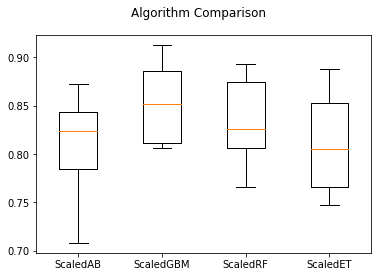

In [27]:
#compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

It looks like GBM regressor has the better score (0.8528)

## 9. Tunne ensemble methods
The default number of boosting stages to perform (n estimators) is 100. This is a good candidate parameter of Gradient Boosting to tune. Often, the larger the number of boosting stages, the better the performance but the longer the training time. In this section we will look at tuning the number of stages for gradient boosting. Below we deﬁne a parameter grid n estimators values from 50 to 400 in increments of 50. Each setting is evaluated using 10-fold cross-validation.

In [28]:
#Tunne scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
estimators = numpy.array([50,100,150,200,250,300,350,400])
param_grid = dict(n_estimators=estimators)
model = GradientBoostingRegressor(random_state=seed)
kfol = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
#print the results of the param grid
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.858218 using {'n_estimators': 50}
0.858218 (0.038574) with: {'n_estimators': 50}
0.853075 (0.039848) with: {'n_estimators': 100}
0.846866 (0.039434) with: {'n_estimators': 150}
0.841831 (0.041601) with: {'n_estimators': 200}
0.837929 (0.042684) with: {'n_estimators': 250}
0.834112 (0.043274) with: {'n_estimators': 300}
0.830538 (0.044111) with: {'n_estimators': 350}
0.827294 (0.044942) with: {'n_estimators': 400}


We can see that the best conﬁguration was n estimators=50 resulting in a R2 of 0.8582

## 10. Finalize model
In this section we will ﬁnalize the gradient boosting model and evaluate it on our hold out validation dataset. First we need to prepare the model and train it on the entire training dataset. This includes standardizing the training dataset before training.

In [30]:
#pre-process training data
#handle categorical data
X_categorical = dataset_train.select_dtypes(include='object')
labelencoder = LabelEncoder()
X_categorical['sex'] = labelencoder.fit_transform(X_categorical['sex'])
X_categorical['smoker'] = labelencoder.fit_transform(X_categorical['smoker'])
X_categorical['region'] = labelencoder.fit_transform(X_categorical['region'])
onehot_encoder = OneHotEncoder()
X_categorical = onehot_encoder.fit_transform(X_categorical).toarray()
#handle numerical data
X_numerical = dataset_train.select_dtypes(include=['float64','int64'])
Y_train = X_numerical['charges'].values
X_numerical = X_numerical.drop(['charges'], axis=1).values
#join X_categorical and X_numerical
X_train = numpy.hstack((X_numerical, X_categorical))
#standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_train.shape

(1070, 11)

In [31]:
#prepare and train the model
model = ExtraTreesRegressor(random_state=seed, n_estimators=300)
model.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=300, n_jobs=None, oob_score=False,
                    random_state=7, verbose=0, warm_start=False)

In [32]:
#pre-process validation data
#handle categorical data
X_categorical = dataset_val.select_dtypes(include='object')
labelencoder = LabelEncoder()
X_categorical['sex'] = labelencoder.fit_transform(X_categorical['sex'])
X_categorical['smoker'] = labelencoder.fit_transform(X_categorical['smoker'])
X_categorical['region'] = labelencoder.fit_transform(X_categorical['region'])
X_categorical = onehot_encoder.transform(X_categorical).toarray()
#handle numerical data
X_numerical = dataset_val.select_dtypes(include=['float64','int64'])
Y_val = X_numerical['charges'].values
X_numerical = X_numerical.drop(['charges'], axis=1).values
#join X_categorical and X_numerical
X_val = numpy.hstack((X_numerical, X_categorical))
#standardize data
X_val = scaler.transform(X_val)
X_val.shape

(268, 11)

In [33]:
from math import sqrt
from scipy.stats import pearsonr

In [34]:
#transform the validation dataset
#rescaledValX = scaler.transform(X_val)
predictions = model.predict(X_val)
print('MSE: ', mean_squared_error(Y_val, predictions))
print('RMSE: ', sqrt(mean_squared_error(Y_val, predictions)))
print('R2: ', r2_score(Y_val, predictions))
corr, _ = pearsonr(Y_val, predictions)
print('Correlation: ', corr)

MSE:  26208477.978249222
RMSE:  5119.42164489791
R2:  0.8361804051634336
Correlation:  0.9147598380931052


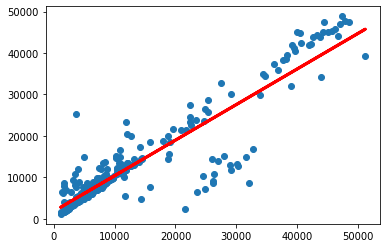

In [35]:
# plot
pyplot.scatter(Y_val, predictions)
#pyplot.show()
lr = LinearRegression().fit(Y_val.reshape(-1,1), predictions.reshape(-1,1))
pyplot.plot(Y_val.reshape(-1,1), lr.predict(Y_val.reshape(-1,1)), color='red', linewidth=3)
pyplot.show()